# On the Suitability of RTT Measurements for Geolocation

rev. 0, 29 August 2017, [Brian Trammell](mailto: ietf@trammell.ch), Networked Systems Group, ETH Zürich

#### Abstract

It is widely understood in the network measurement community that round trip time measurements, whether passively derived by observation of transport-layer or application-layer signals linking packets in one direction to counterparts in another, or actively measured using a facility such as ICMP echo reply, are not on their own useful as input to trilateration for geolocation, as they are dominated by error terms which are not easy to remove. While detailing several attempts to correct for this error in order to use RTT measurements for certain geolocation tasks appear in the literature, there has not to date been an attempt to provide a quantitiative, empirical study of this error as guidance for applying RTT measurements for geolocation.

This work uses RTTs derived from RIPE Atlas Ping measurements to address this shortcoming. This dataset is especially useful in that we have presumptive ground truth for the locations o Atlas probes and a set of dedicated measurement targets, called Atlas anchors, which allows us to compare our RTT-derived estimated distances to actual distances, as well as to derive empirical models for a function deriving distance from observed RTT.

_Conclusions from the study go here_. 

#### About this notebook

This is a Jupyter notebook containing the analysis code used to generate its visualizations; it is, in a sense, a "runnable paper". It depends on the [dataprep](dataprep.ipynb) notebook in this directory to download measurements from RIPE Atlas and place them in distilled form in an HDF5 datastore, from which this paper reads data and generates visualizations and tables. If you don't have an HDF5 datastore locally, go run the [dataprep](dataprep.ipynb) notebook now, then come back here.

Run the following cell to set up the environment, import useful packages, define visualization functions, and load the dataframes from which this paper's analysis and visualization will follow:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") 

def plot_rtt_series(aid, pid): 
    """
    Given an anchor and probe ID, plot the time series of RTTs, 
    separately for IPv4 and IPv6.
    
    """

    example_ts_df = rtt_df[(rtt_df['aid'] == aid) & (rtt_df['pid'] == pid)].loc[:,['time','rtt','af']]

    example_ts_df_ip4 = example_ts_df[example_ts_df['af'] == 4]
    example_ts_df_ip6 = example_ts_df[example_ts_df['af'] == 6]
    plt.plot(example_ts_df_ip4['time'],example_ts_df_ip4['rtt'],".")

    plt.plot(example_ts_df_ip6['time'],example_ts_df_ip6['rtt'],".")

    plt.xlabel("time")
    plt.ylabel("RTT µs")
    plt.legend(labels=['ip4','ip6'])
    plt.title("RTT series for {} ({}) from probe {}".format(anchor_df.loc[aid]['name'], aid, pid))

def _point_at_bearing(lon1, lat1, b, r):
    """
    Shoot a bearing at a given distance (in units of Earth radius) from a given long
    """
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def _circle_with_radius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius in kilometers
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = _point_at_bearing(lon, lat, bearing, km / 6371)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles_for(aid, amin_df=None, pids=None, mapscale=None, whichkm='c_km'):
    # First, get a dataframe containing only the datapoints for the anchor and probes selected
    if amin_df is None:
        amin_df = min_df.loc[aid].loc[pids]
    
    # Now draw the basemap, scaled to fit most of the circles we'll draw
    if mapscale is None:
        mapscale = amin_df[whichkm].max() * 2500 
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=(10,10))
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='c',projection='robin',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')
    
    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row[whichkm]
        if km > ( 6371 * math.pi ):
            continue
        clon, clat = _circle_with_radius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-', alpha=0.33)
    
    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")
    
    # And title
    plt.title("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name']))



In [2]:
## Now load some data from the HDF store the dataprep notebook left us.
    
with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']
    
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min(), 
                       'n':      rtt_df.groupby(['aid','pid'])['rtt'].count()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

# turn minimum RTT into distance
c = 299792458 # speed of light in meters per second
FIBER_REFRACTION = 1.4677 # assume Corning glass is typical
min_df['c_km'] = (c / 1e9) * (min_df['minrtt'] / 2)
min_df['fiber_km'] = ((c / 1e9) / FIBER_REFRACTION) * (min_df['minrtt'] / 2) # estimate refractive index of glass at 1.5

## Introduction

In this work, we seek to answer the question "how useful is Internet end-to-end round-trip-time (RTT; also known as two-way delay) measurement to the problem of locating an endpoint with unknown location, given known location for other endpoint(s) it communicates with?"; or in the more negative sense, "how much risk does exposure of one's end-to-end RTT pose to the geographical privacy of a given endpoint?". We examine this question in two ways: by attempting to use RTT data as input for geolocation by [trilateration](https://en.wikipedia.org/wiki/Trilateration), and by attempting to localize by exclusion.

For trilateration, we must find a function of RTT that yields a distance:

$$ dist = f(RTT) $$

We first note that observable RTT is given by the equation:

$$ RTT_{obs} = \sum_{n=0}^f(D_{prop_{n \rightarrow n+1}} + D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{prop_{m \rightarrow m+1}} + D_{queue_m} + D_{proc_m}) + D_{app} $$

In other words, for _f_ hops in the forward direction and _r_ hops in the reverse direction, the observed RTT is the sum of propagation, queueing, and processing delay at each hop, plus any delay at the far endpoint (here labeled as application delay). The idealized RTT for geolocation purposes, however, would be:

$$ RTT_{ideal} = \sum_{n=0}^f D_{prop_{n \rightarrow n+1}} + \sum_{m=0}^r D_{prop_{m \rightarrow m+1}} $$

This ideal situation only holds in the unlikely circumstance that sources of error (i.e., variable queueing delay, unmeasurable processing delay, and application delay) are zero:

$$ RTT_{obs} = RTT_{ideal} \iff RTT_{error} = \sum_{n=0}^f(D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{queue_m} + D_{proc_m}) + D_{app} = 0 $$

Even this impossible, idealized situation would not yield us a perfect $dist = f(RTT)$, as the propagation delays themselves follow the paths of the optical fiber, copper wire, radio or optical wireless link carrying each hop, which do not follow straight lines, and each of which may have its own functions determining distance given delay. Nevertheless we will first look at the distribution of $RTT_{obs}$ versus known distances using the [RIPE Atlas](https://atlas.ripe.net) measurement network, in order to determine whether an $f(RTT)$ suitable for trilateration can be derived.

Failing that, the only thing we can say with complete certainty is that distance given an estimated one-way delay cannot be equal to or greater than the speed of light:

$$ dist < \frac{RTT_{obs}}{2} \times c $$

We therefore then turn our attention to geolocation by exclusion: by taking RTT measurements from a set of vantage points with known locations, by determining the locations where an endpoint cannot be based on the inequality above for each vantage point, then taking the union of all those locations: the endpoint must therefore be somewhere within the area outside of those areas it cannot be.

We conclude that _conclusions go here_.

### Related Work

The question addressed by this paper has been addressed recently. Cicalese et al <sup>1</sup> use active measurements of latency to discover anycast infrastructure in the Internet, using geolocation by exculsion from multiple vantage points to conclude that a target whose exclusion circles do not overlap must be multiply located; however, the technique proposed must revert to relatively complicated heuristics specific to infrastructure location in order to achieve city-level geolocation, and the specific question we posed here is only addressed in an initial description of the difficulty of the problem of processing latency data for exclusion and location.

Specifically addressing latency-based threats to privacy, Hopper et al <sup>2</sup> describe a latency-based attack on anonymizing systems, by correlating time series changes in latency in order to "fingerprint" circuits in an online anonymity network. The insights from this work, however, are not applicable to the generalized problem of latency-based geolocation in the Internet, since they require the stability of circuits as in a mixnet. 

- - - 

*Notes:* 

<sup>1</sup> "Latency-Based Anycast Geolocation: Algorithms, Software, and Data Sets" in IEEE JSAC 34(6), June 2016, [doi 10.1109/JSAC.2016.2558898](http://ieeexplore.ieee.org/document/7470242/)

<sup>2</sup> "How Much Anonymity does Network Latency Leak?" in ACM TISSEC 13(2), February 2010, doi [10.1145/1698750.1698753](http://doi.acm.org/10.1145/1698750.1698753)



## Methodology

_frontmatter_

### Data Source and Preparation

We use RTT data taken from the [RIPE Atlas](https://atlas.ripe.net) measurement network, selecting a set of 32 anchors from the more than 200 deployed; the list of selected anchors is shown in [the dataprep notebook](dataprep.ipynb#Anchor-Selection). We then find ping (ICMP echo request/reply) measurements targeted to each of these anchors, and consider round trip times from each of the 4007 probes used in these measurements. This yields a set of 13,780 distinct probe/anchor pairs: not every probe contacts every anchor, and vice-versa. We use this data set not only for its openness, but also since we have ground truth for the location of the anchors, and presumably low-error location estimates for the probes, whose locations are self-reported by their hosts.

In [3]:
# Get locations of anchors and probes in the dataset
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

In [4]:
# How many probes are there?
len(ploc_df)

4007

In [5]:
# And how many probe/anchor pairs?
len(min_df)

13780

The set of anchors and probes used in these anchoring measurements is plotted on the map below:

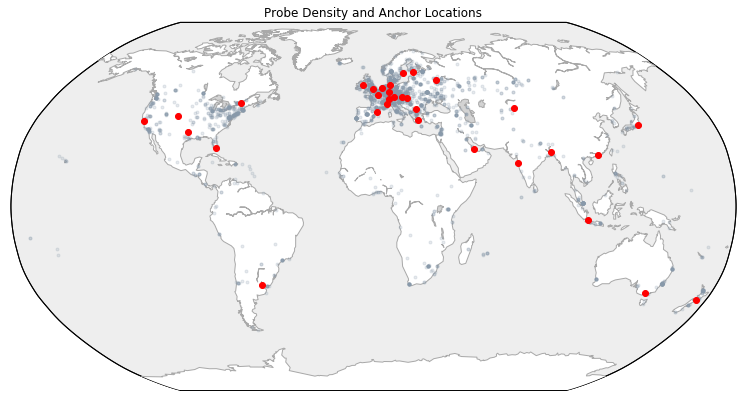

In [6]:
# Plot all anchors and probes on the world map
plt.figure(figsize=(13,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines(color="darkgrey")
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,".",alpha=0.2,color="#8899aa")
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Since the RIPE Atlas network is Europe-centric, we have more probes and anchors in Europe; the map below shows a Europe-centered view of the probes and anchors used:

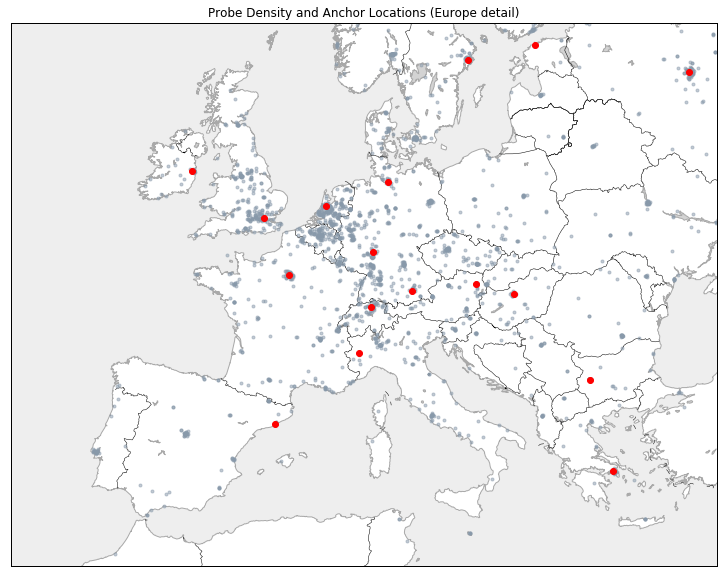

In [7]:
plt.figure(figsize=(13,10))
m = Basemap(width=3900000, height=3000000, projection='laea',lat_0=48,lon_0=8,resolution='i')
m.drawcoastlines(color="darkgrey")
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawcountries()
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations (Europe detail)")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,".",alpha=0.5, color="#8899aa")
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Since the error terms in $RTT_{error}$ are more variable than those in $RTT_{ideal}$, we take a number of RTT measurements from each probe/anchor pair, and take the minimum from each pair. This reduces our set of 6,187,693 raw measurements to 13,780 minumum $RTT_{obs}$, one per anchor/probe pair. We have up to 540 samples per path (three samples per measurement, measurements taken every four minutes, via IPv4 and IPv6, for six hours).

In [8]:
# How many raw measurements do we have?
len(rtt_df)

6187693

### Illustration of RTT dynamics

Our data set includes a variety of RTT dynamic behaviors which illustrate the need to reduce the dataset by taking the minumum RTT for each probe/anchor pair present, as well as illustrating the utility of time-series latency measurements for other purposes. Some pairs show relatively low variability, but better performance using one address family as opposed to another; the Atlas anchor in Sofia, for example, is 11% faster via IPv6 than via IPv4 from probe [6072](https://atlas.ripe.net/probes/6072/):

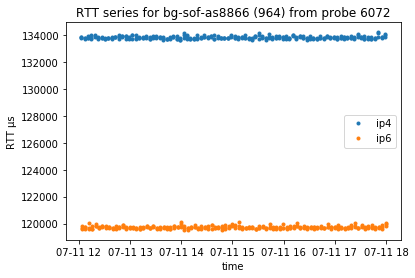

In [9]:
plot_rtt_series(964, 6072)

The RTT time series can also be quite discontinuous: here, the IPv4 route between probe [21995](https://atlas.ripe.net/probes/6072/) and the anchor in Dacca changed during the measurement, and latency increased significantly. Note also that the new path shows far more latency variability than the old one, indicating congestion or load on the new path. It is precisely this sort of dynamic which is useful for detection and diagnostics in network operations.

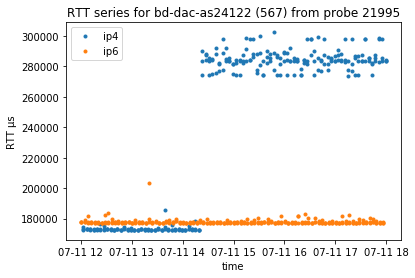

In [10]:
plot_rtt_series(567, 21995)

Neither of these examples are particularly useful for exclusion-based geolocation, however: the latencies are too high. The ~122ms measurement from probe 6072 toward the Sofia anchor can only conclusively state that the anchor is not in Perth, so we'll have to focus on RTT series with lower latencies in order to have any realistic chance of geolocating anchors.

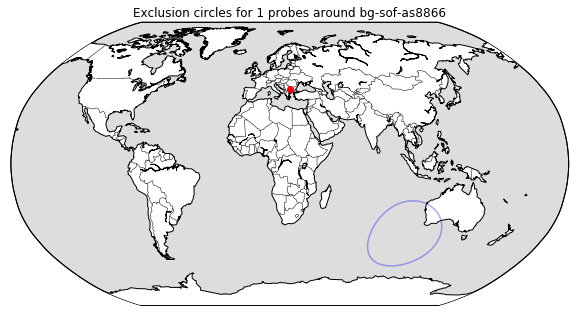

In [11]:
plot_exclusion_circles_for(964, pids=[6072], whichkm="c_km")

## Results 

_frontmatter_

### Distance Error Distribution

_show empirical RTT function, explain discontinuities_

_show error ECDFs per anchor and total_

### Geolocation by Exclusion

_show a few examples. use shapely with projected circles to look at exclusion areas per anchor. for the most part, only the lowest RTT matters. do we want to look at confusables in Europe?_